## **Assignment 2**  
**02805 Social Graphs & Interactions**  

**Group 13** 
- Anna Bøgevang Ekner (s193396)
- Morten Møller Christensen (s204258)


**Feedback from Assignment 1**
- Don't scale the axes of the distributions (especially not x-axis), because we distort the distributions and will arrive to wrong conclusions. He said our in- and out-degree distributions look kinda weird and not how they would expect. 
- Instead of using plt.hist, bin the data as described in the Week 2 notebook and then plot with plt.bar. Make sure that when we do comparisons of distributions, the data should be binned in the same way. 

In [80]:
import warnings
warnings.filterwarnings('ignore')
import random
import os
import re
import json
import scipy
import urllib.request
import urllib.parse
import numpy as np
import networkx as nx
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from tqdm import tqdm
from itertools import count
import community
from fa2_modified import ForceAtlas2
from collections import Counter, defaultdict
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from wordcloud import WordCloud


sns.set_style('darkgrid')
sns.set(font_scale=1.)

# **Part 1: Genres and communities and plotting**

### **Loading and pre-processing the undirected graph**

In [2]:
def load_data():
    """
    Load the artist genre data and the undirected country musician graph

    Returns
        artist_genres_dict: dictionary of artist genres (dict)
        country_performer_undir_graph: undirected graph of country musicians (nx.Graph)
    """
    # Load the artist genre data
    artist_genres = open('artists_genres_dictionary.txt', 'r')
    raw_data = artist_genres.read() 

    # Convert into dictionary
    artist_genres_dict = eval(raw_data)

    # Load the undirected graph from the json file
    with open('undirected_graph.txt', 'r', encoding='utf-8') as f:
        undirected_graph_json = json.load(f)

    undirected_graph_data = json.loads(undirected_graph_json)
    country_performer_undir_graph = nx.node_link_graph(undirected_graph_data)

    return artist_genres_dict, country_performer_undir_graph

artist_genres_dict, country_performer_undir_graph = load_data()


Delete the cell below:

In [3]:
# Check the counts of each genre (value) in the artist_genres_dict
genres = list(artist_genres_dict.values())
genres_flat = [x for xs in genres for x in xs]
values, counts = np.unique(genres_flat, return_counts=True)
not_one = (counts != 1).sum()
# print(not_one)
# print(values)

# Dictionary of genre and their counts
genre_counts = dict(zip(values, counts))

# sort after highest values
genre_counts = dict(sorted(genre_counts.items(), key=lambda item: item[1], reverse=True))
print(genre_counts)

{'country': 1499, 'folk': 178, 'country rock': 171, 'americana': 157, 'pop': 157, 'bluegrass': 129, 'rock': 116, 'country pop': 109, 'gospel': 96, 'rockabilly': 80, 'blues': 79, 'alternative country': 73, 'folk rock': 60, 'southern rock': 51, 'rock and roll': 50, 'outlaw country': 40, 'country music': 36, 'pop rock': 35, 'jazz': 34, 'soft rock': 34, 'progressive country': 31, 'roots rock': 29, 'neotraditional country': 27, 'western swing': 27, 'blues rock': 24, 'honky-tonk': 23, 'soul': 23, 'alternative rock': 20, 'texas country': 20, 'western': 20, 'hard rock': 19, 'progressive bluegrass': 17, 'country folk': 15, 'red dirt': 15, 'traditional pop': 15, 'nashville sound': 14, 'old-time': 14, 'country rap': 12, 'honky tonk': 12, 'indie rock': 12, 'bakersfield sound': 11, 'christian': 11, 'hip hop': 11, 'ccm': 10, 'indie folk': 10, 'heartland rock': 9, 'old-time music': 9, 'adult contemporary': 8, 'alt-country': 8, 'ameripolitan': 8, 'countrypolitan': 8, 'jam band': 8, 'southern gospel': 

In [4]:
def preprocess_graph(artist_genres_dict, country_performer_undir_graph):
    """ 
    Preprocess the graph by keeping only the nodes that have genre information, 
    and also remove the article_length attribute from all nodes.

    Args
        artist_genres_dict: dictionary of artist genres (dict)
        country_performer_undir_graph: undirected graph of country musicians (nx.Graph)

    Returns
        artist_undirected_graph: preprocessed undirected graph of country musicians (nx.Graph)
    """
    # Keep only the nodes that have genre information
    artist_undirected_graph = country_performer_undir_graph.copy()

    for node in list(country_performer_undir_graph.nodes()):

        # Remove the article_length attribute
        if 'article_length' in artist_undirected_graph.nodes[node]:
            del artist_undirected_graph.nodes[node]['article_length']

        if node.replace('_', ' ') not in artist_genres_dict:
            artist_undirected_graph.remove_node(node)

    return artist_undirected_graph

artist_undirected_graph_preprocessed = preprocess_graph(artist_genres_dict, country_performer_undir_graph)

print(f'Artist genre dictionary')
print(f'\tNumber of artists: {len(artist_genres_dict)}\n')

print(f'Artist graph (undirected)')
print(f'\tNumber of nodes: {artist_undirected_graph_preprocessed.number_of_nodes()}')
print(f'\tNumber of edges: {artist_undirected_graph_preprocessed.number_of_edges()}')

Artist genre dictionary
	Number of artists: 1833

Artist graph (undirected)
	Number of nodes: 1833
	Number of edges: 13943


### **Exercise 1.1: Genres and modularity**

Write about genres and modularity. 

See Network Science, Section 9.4, and reference it with: [[Network Science, Section 9.4]](https://networksciencebook.com/chapter/9#modularity) 

Mention Equation (9.12): 

\begin{equation}
M = \sum\limits^{n_c}_{c=1} \left[ \dfrac{L_c}{L} - \left(\dfrac{k_c}{2L}\right)^2 \right], \quad (\text{Equation } 9.12)
\end{equation}

where $L$ is the number of links in the network, $n_c$ is the number of communities in the partition, while $L_c$ and $k_c$ are the number of links and total degree of the nodes, respectively, for the community $c$. 

### **Exercise 1.2: Detecting communities and the value of modularity in comparison to the genres**

Detect the communities, discuss the value of modularity in comparison to the genres. 

In [5]:
def add_genre_attribute(artist_genres_dict, artist_undirected_graph, selection_method = 'first'):
    """
    Add the genre attribute to the nodes in the graph, either by selecting the 
    first genre in the list or by selecting the first genre that is not 'country'.

    Args
        artist_genres_dict: dictionary of artist genres (dict)
        artist_undirected_graph: undirected graph of country musicians (nx.Graph)
        selection_method: method to select the genre, either 'first' or 'not_country' (str)

    Returns
        artist_undirected_graph: undirected graph of country musicians with genre attribute (nx.Graph)
    """

    for node in list(artist_undirected_graph.nodes()):

        # Get the genres of the artist
        genres = artist_genres_dict[node.replace('_', ' ')]

        # Select the genre based on the selection method
        if selection_method == 'first':
            genre = genres[0]

        elif selection_method == 'not_country':

            # If the artist has only one genre, select it
            if len(genres) == 1:
                print(node)
                genre = genres[0]

            # If the artist has multiple genres, select the first genre that is not 'country'
            else:
                genre = [g for g in genres if g != 'country'][0]
        
        # Add the genre attribute to the node
        artist_undirected_graph.nodes[node]['genre'] = genre


    return artist_undirected_graph

def find_communities_genres(artist_undirected_graph):
    """
    Find the communities in the graph, i.e. groups of nodes that share the same genre.
    Each node is characterized by the first genre in its list of genres.

    Args
        artist_undirected_graph: undirected graph of country musicians (nx.Graph)

    Returns
        communities: dictionary of communities, where keys are genres and values are 
                     nodes characterized by that genre (dict)
    """

    # Get all genres present in the graph
    all_genres = set(nx.get_node_attributes(artist_undirected_graph, 'genre').values())

    # Dictionary for the communities with each genre as key
    communities = {genre: [] for genre in all_genres}

    for node in artist_undirected_graph.nodes():

        # Get genre of the node
        genre = artist_undirected_graph.nodes[node]['genre']

        # Add the node to the corresponding community
        communities[genre].append(node)

    return communities

def compute_modularity(artist_undirected_graph, communities):
    """
    Compute the modularity of the graph, i.e. the strength of the partition of the graph into communities.

    Args
        artist_undirected_graph: undirected graph of country musicians (nx.Graph)
        communities: dictionary of communities (dict)

    Returns
        modularity: modularity of the graph (float)
    """

    L = artist_undirected_graph.number_of_edges()  # Total number of links in the graph
    n_c = len(communities)                         # Number of communities
    community_modularities = np.zeros(n_c)         # Array for storing the modularity values of each community
    
    for i, c in enumerate(communities.keys()):
        
        # Number of links in the community
        L_c = artist_undirected_graph.subgraph(communities[c]).number_of_edges()

        # Sum of the degrees of the nodes in the community
        k_c = np.sum([artist_undirected_graph.degree[node] for node in communities[c]])

        # Modularity value for the community
        community_modularities[i] = L_c / L - (k_c / (2 * L))**2

    # Modularity of the partition
    modularity = np.sum(community_modularities)

    return modularity

**Communities and modularity when each artist is characterized by their first genre**

In [6]:
# Add the genre attribute to the nodes in the graph (selecting the first genre)
artist_undirected_graph = add_genre_attribute(artist_genres_dict, artist_undirected_graph_preprocessed, selection_method = 'first')

# Find communities in the graph based on genre
communities = find_communities_genres(artist_undirected_graph)

# Compute the modularity of the partition
modularity = compute_modularity(artist_undirected_graph, communities)

print(f'Partion of the artist graph based on genre')
print(f'\tSelection method: first genre')
print(f'\tNumber of communities: {len(communities)} communities')
print(f'\tLargest community: {max([len(communities[genre]) for genre in communities])} artists')
print(f'\tSmallest community: {min([len(communities[genre]) for genre in communities])} artist')
print(f'\tModularity: {modularity:.4f}')

Partion of the artist graph based on genre
	Selection method: first genre
	Number of communities: 112 communities
	Largest community: 1221 artists
	Smallest community: 1 artist
	Modularity: 0.0713


**Communities and modularity when each artist is characterized by their first genre that is not `country`**

In [7]:
# Add the genre attribute to the nodes in the graph (selecting the first genre that is not 'country')
artist_undirected_graph = add_genre_attribute(artist_genres_dict, artist_undirected_graph_preprocessed, selection_method = 'not_country')

# Find communities in the graph based on genre
communities = find_communities_genres(artist_undirected_graph)

# Compute the modularity of the partition
modularity = compute_modularity(artist_undirected_graph, communities)

print(f'Partion of the artist graph based on genre')
print(f'\tSelection method: first genre that is not "country"')
print(f'\tNumber of communities: {len(communities)} communities')
print(f'\tLargest community: {max([len(communities[genre]) for genre in communities])} artists')
print(f'\tSmallest community: {min([len(communities[genre]) for genre in communities])} artist')
print(f'\tModularity: {modularity:.4f}')

The_Jenkins
Great_Plains_(Tennessee_band)
Craig_Morgan
Chad_Brock
Amie_Comeaux
Aaron_Barker
Philip_Claypool
Neal_McCoy
Doug_Supernaw
Clay_Walker
Dean_Dillon
Monty_Holmes
Blue_County_(music_group)
Aaron_Lines
Paul_Brandt
Aaron_Pritchett
Jordan_McIntosh
Jessie_Farrell
Toby_Keith
George_Canyon
One_More_Girl
Josh_Logan_(country_singer)
David_Lee_Murphy
Mark_Collie
Dallas_Frazier
Mel_Tillis
Bob_Wills
Adam_Brand_(musician)
Melinda_Schneider
Travis_Collins
Adam_Gregory
John_Schneider_(screen_actor)
Adam_Harvey
Troy_Cassar-Daley
Beccy_Cole
Tania_Kernaghan
Pat_Green
Ricochet_(band)
Brad_Paisley
Shenandoah_(band)
Rodney_Crowell
The_Wrights_(country_duo)
Charly_McClain
Keith_Stegall
Phil_Vassar
Gene_Watson
Alecia_Elliott
Lorrie_Morgan
Alecia_Nugent
Alee_(singer)
Dianna_Corcoran
Amber_Lawrence
Blake_Shelton
Alyssa_Micaela
Eli_Young_Band
Ty_England
Hal_Ketchum
James_Otto
Tim_McGraw
Lari_White
Mike_Walker_(singer)
Jeffrey_Steele
Linda_Davis
Hot_Apple_Pie
Al_Dexter
Luke_Combs
Don_Williams
Amanda_Wilk

In [8]:
def find_communities_louvain(artist_undirected_graph):
    """
    Find the communities in the graph using the Louvain algorithm.

    Args
        artist_undirected_graph: undirected graph of country musicians (nx.Graph)

    Returns
        communities: dictionary of communities, where keys are genres and values are 
                     nodes characterized by that genre (dict)
    """
    # Run Louvain algorithm
    communities_louvain = nx.community.louvain_communities(artist_undirected_graph, seed = 0)

    # Dictionary for the communities with each genre as key
    communities = {}

    for i, community in enumerate(communities_louvain):
        
        # Add each artist in the community to the dictionary
        communities[i] = list(community)
    
    return communities

def find_communities_genres_all(artist_genres_dict):
    """ 
    Find the communities in the graph, where each node is characterized by all of the genres in its list of genres.

    Args
        artist_genres_dict: dictionary of artist genres (dict)

    Returns
        communities: dictionary of communities, where keys are genres and values are 
                     nodes characterized by that genre (dict)
    """
    
    # Get all unique values from the dictionary
    all_genres = set([genre for genres in artist_genres_dict.values() for genre in genres])

    # Dictionary for the communities with each genre as key
    communities = {genre: [] for genre in all_genres}

    for artist in artist_genres_dict.keys():
        
        # Get the genres of the artist
        genres = artist_genres_dict[artist]

        for genre in genres:
            communities[genre].append(artist.replace(' ', '_'))

    return communities

In [9]:
# Find communities in the graph based on genre (selecting all genres for each artist)
communities_genres_all = find_communities_genres_all(artist_genres_dict)

# Find communities in the graph based on Louvain algorithm
communities_louvain = find_communities_louvain(artist_undirected_graph)

# Compute the modularity of the partition (Louvain)
modularity = compute_modularity(artist_undirected_graph, communities_louvain)

print(f'Partion of the artist graph based on Louvain algorithm')
print(f'\tNumber of communities: {len(communities_louvain)} communities')
print(f'\tLargest community: {max([len(communities_louvain[i]) for i in communities_louvain])} artists')
print(f'\tSmallest community: {min([len(communities_louvain[i]) for i in communities_louvain])} artist')
print(f'\tModularity: {modularity:.4f}')

Partion of the artist graph based on Louvain algorithm
	Number of communities: 12 communities
	Largest community: 476 artists
	Smallest community: 1 artist
	Modularity: 0.3932


To-do:

- Find Louvain communities with `communities` library (or use `networkx.communities.louvain_communities`), and compute modularity. 


### **Exercise 1.3: Calculating the matrix $D$ and discussing the findings**

In [10]:
def get_n_most_common_communities(community_dict, n=1):
    """
    Get the n most common communities in the community dictionary
    
    Args
        community_dict: dictionary of communities (dict)
        n: number of most common communities to return (int)
        
    Returns
        most_common_communities: list of the n most common communities (list)
        community_to_artists: dictionary of genres to artists (dict)
    """

    genre_counts = {genre: len(community_dict[genre]) for genre in community_dict}
    most_common_communities = sorted(genre_counts, key=genre_counts.get, reverse=True)[:n]

    community_to_artists = {genre: community_dict[genre] for genre in most_common_communities}
    

    return community_to_artists

communities_louvain_common = get_n_most_common_communities(communities_louvain, n=7)
communities_genres_all_common = get_n_most_common_communities(communities_genres_all, n=7)
communities_genres_not_country_as_first_common = get_n_most_common_communities(communities, n=7)

7
12


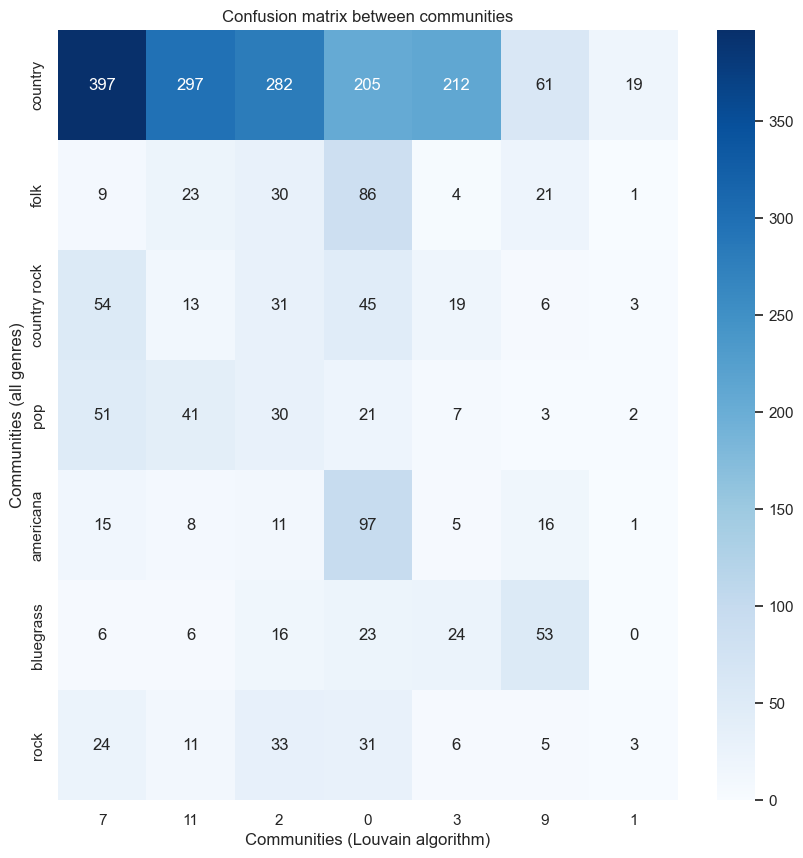

In [11]:
def create_confusion_matrix(communities_louvain_common, communities_genres_all_common):
    """
    Create a confusion matrix between the communities found by the Louvain algorithm and the communities based on all genres

    Args
        communities_louvain_common: dictionary of communities found by Louvain algorithm (dict)
        communities_genres_all_common: dictionary of communities based on all genres (dict)

    Returns
        confusion_matrix: confusion matrix between the communities (np.array)
    """

    confusion_matrix = np.zeros((len(communities_louvain_common), len(communities_genres_all_common)))
    for i, genre_louvain in enumerate(communities_louvain_common): 
        for j, genre_all in enumerate(communities_genres_all_common):
            intersection = set(communities_louvain_common[genre_louvain]) & set(communities_genres_all_common[genre_all])
            confusion_matrix[j, i] = len(intersection)

    return confusion_matrix




D = create_confusion_matrix(communities_louvain_common, communities_genres_all_common)

def plot_confusion_matrix(D, communities_louvain_common, communities_genres_all_common):
    """
    Plot the confusion matrix between the communities found by the Louvain algorithm and the communities based on all genres

    Args
        D: confusion matrix between the communities (np.array)
        community_louvain_dict: dictionary of communities found by Louvain algorithm (dict)
        community_genres_all_dict: dictionary of communities based on all genres (dict)
    """

    fig, ax = plt.subplots(figsize=(10, 10))
    
    sns.heatmap(D, annot=True, fmt='g', cmap='Blues',
                xticklabels=communities_louvain_common, 
                yticklabels=communities_genres_all_common)
    
    plt.xlabel('Communities (Louvain algorithm)')
    plt.ylabel('Communities (all genres)')
    plt.title('Confusion matrix between communities')
    plt.show()

plot_confusion_matrix(D, communities_louvain_common, communities_genres_all_common)

To-do:

- Confusion matrix of comparison between genre (with `all` selection method) vs. communities, and discuss. 

### **Exercise 1.4: Plotting the communities**

To-do:

- Plot and compare communities found based on genre vs. communities found based on Louvain algorithm. 

In [12]:
def FA2_positions(artist_undirected_graph, pos, iterations=200):
    """
    Compute the ForceAtlas2 layout for the graph

    Args
        artist_undirected_graph: undirected graph of country musicians (nx.Graph)
        pos: initial positions of the nodes (dict)
        iterations: number of iterations for the layout (int)

    Returns
        positions: positions of the nodes after the layout (dict)
    """
    forceatlas2 = ForceAtlas2(
        outboundAttractionDistribution=True,  
        edgeWeightInfluence=1.0,
        jitterTolerance=0.5,  
        barnesHutOptimize=True,
        barnesHutTheta=1.8,  # Lower to increase structure
        scalingRatio=1.0,  # Reduce to prevent large spread
        strongGravityMode=False,
        gravity=0.1,  # Lower to reduce overlap
        verbose=True
    )

    # Compute the layout
    positions = forceatlas2.forceatlas2_networkx_layout(artist_undirected_graph, pos=pos, iterations=iterations)

    return positions
def assign_colors_by_genre(graph, genre_dict):
    """
    Assign a unique color ID to each node in the graph based on its genre.

    Args
        graph: undirected graph of country musicians (nx.Graph)
        genre_dict: dictionary of artist genres (dict)

    Returns

        color_assignments: list of color IDs for each node in the graph (list)
    """
    color_assignments = []
    genre_to_color = {genre: index for index, genre in enumerate(genre_dict)}  # Map each genre to a unique color ID
    # print(genre_to_color)

    for node in graph.nodes():
        assigned = False
        for genre, artists in genre_dict.items():
            if node in artists:
                color_assignments.append(genre_to_color[genre])  # Assign the genre’s color ID
                assigned = True
                break
        if not assigned:
            # If the node is not in any genre, assign a default color ID, like -1
            color_assignments.append(-1)
    return color_assignments

def create_plot(artist_undirected_graph, positions, communities, cmap_name, title):
    """
    Create a plot of the artist graph colored by the communities

    Args
        artist_undirected_graph: undirected graph of country musicians (nx.Graph)
        positions: positions of the nodes in the graph (dict)
        communities: dictionary of communities (dict)
        cmap_name: name of the colormap to use (str)
        title: title of the plot (str)
    """

    color_assignments = assign_colors_by_genre(artist_undirected_graph, communities)
    cmap = plt.cm.get_cmap(cmap_name, max(color_assignments) + 1)

    
    nx.draw_networkx_nodes(artist_undirected_graph, positions, node_size=10, node_color=color_assignments, cmap=cmap)
    nx.draw_networkx_edges(artist_undirected_graph, positions, alpha=0.1)
    plt.title(title)
    plt.axis('off')

100%|██████████| 200/200 [00:05<00:00, 33.43it/s]


BarnesHut Approximation  took  1.14  seconds
Repulsion forces  took  4.55  seconds
Gravitational forces  took  0.02  seconds
Attraction forces  took  0.08  seconds
AdjustSpeedAndApplyForces step  took  0.11  seconds


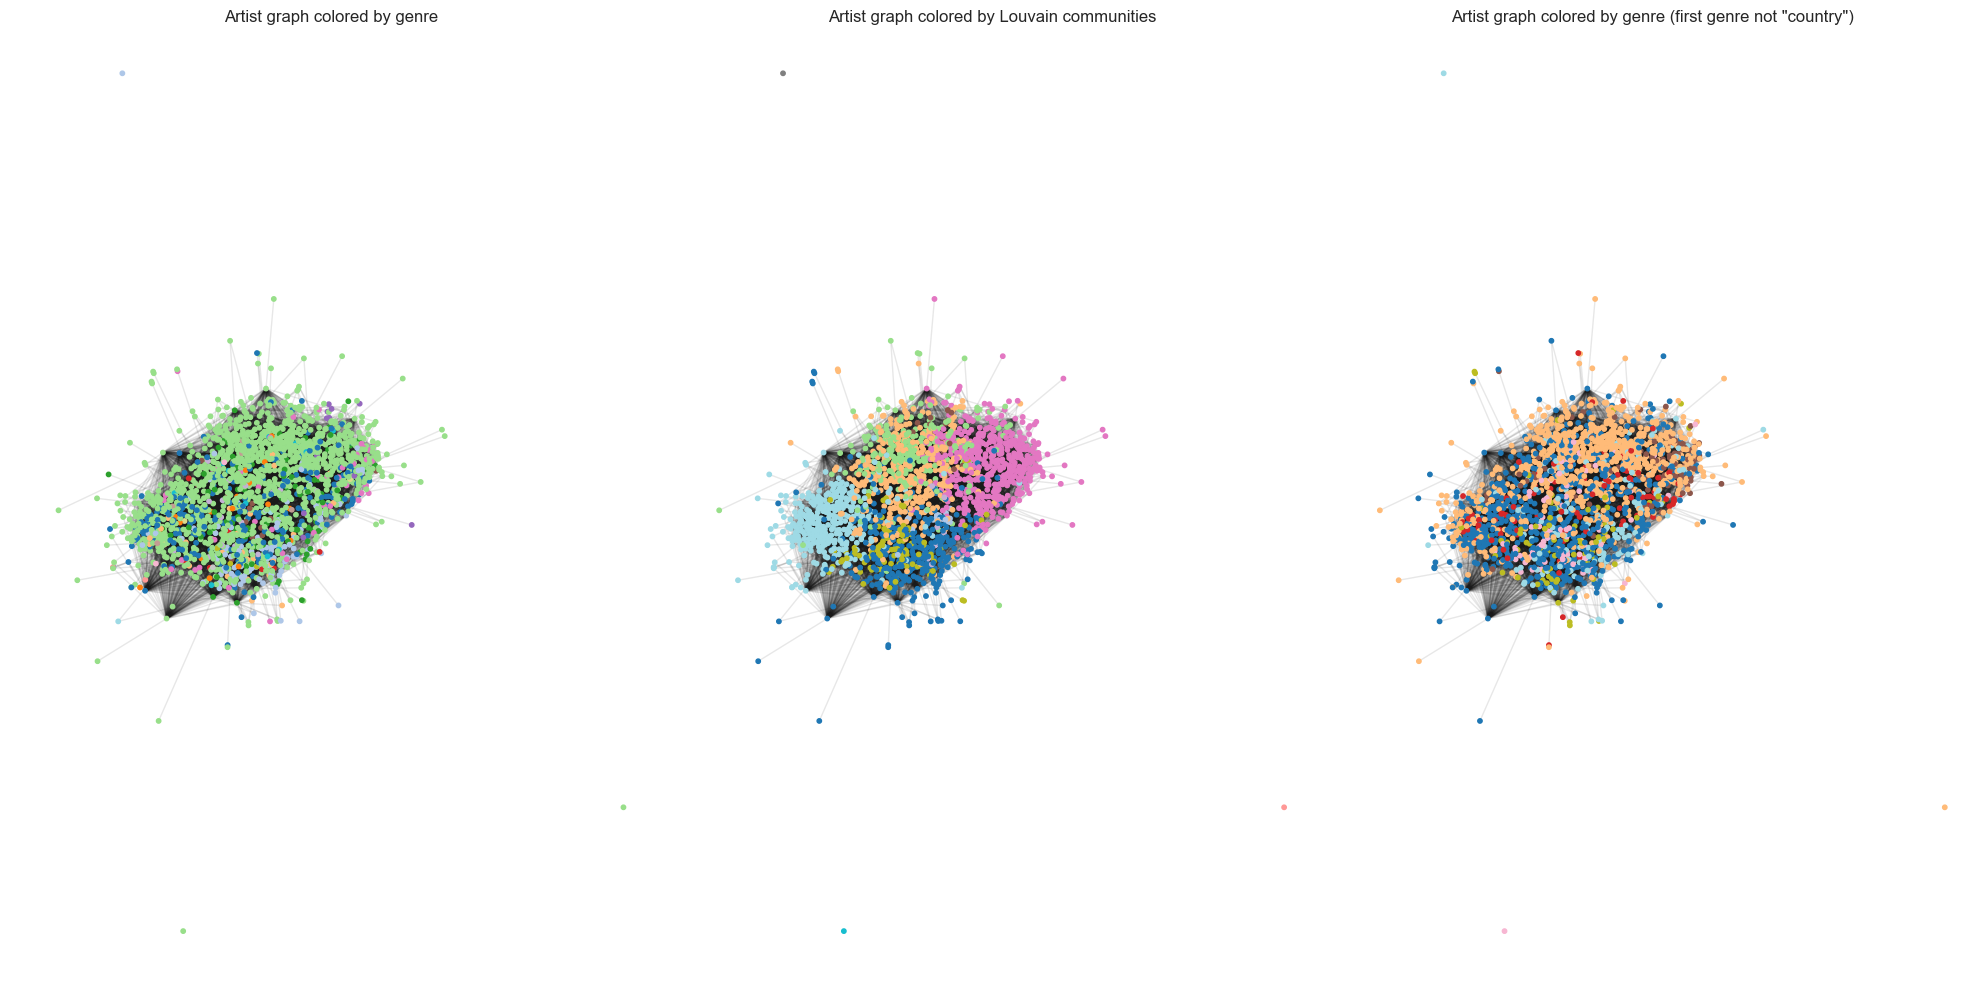

In [13]:
# Which one is the better option, try both
#positions = FA2_positions(artist_undirected_graph, pos=None, iterations=200)
initial_pos = nx.spring_layout(artist_undirected_graph)
positions = FA2_positions(artist_undirected_graph, pos=initial_pos, iterations=200)
plt.figure(figsize=(20, 10))
plt.subplot(1, 3, 1)
create_plot(artist_undirected_graph, positions, communities_genres_all, 'tab20', 'Artist graph colored by genre')
plt.subplot(1, 3, 2)
create_plot(artist_undirected_graph, positions, communities_louvain, 'tab20', 'Artist graph colored by Louvain communities')
plt.subplot(1, 3, 3)
create_plot(artist_undirected_graph, positions, communities_genres_not_country_as_first_common, 'tab20', 'Artist graph colored by genre (first genre not "country")')
plt.tight_layout()
plt.show()

# **Part 2: TF-IDF to understand genres and communities**

### **Exercise 2.1: The concept of TF-IDF**
TF-IDF (short for term frequency-inverse document frequency) is a numerical statistic intended to reflect how important a word is to a document in a collection/corpus. TF-IDF is two statistics that are multiplied together: term frequency and inverse document frequency. While its only two statistics that are multiplied together, each statistic can be defined in various ways. **Term frequency** is at its core a value that describes how often a term appears in a document. Examples of term frequency include raw term frequency, i.e. the number of times a word appears in a document. Another example is to normalize the term frequency by dividing the number of times a word appears in a document by the total number of words in the document.  [[tf–idf]](https://en.wikipedia.org/wiki/Tf%E2%80%93idf)\
More "advanced" techniques for term frequency include the logarithmically scaled term frequency and the augmented term frequency. The logarithmically scaled term frequency is calculated as $1 + \log(tf)$, where $tf$ is the raw term frequency. This measure is used to prevent bias towards longer documents. Ex. if we have a text where one word appears 10 times and another word 100 times, the logarithmical method would reduce the difference between the two words. \
The second part of TD-IDF is the **inverse document frequency**. IDF is a statistic that describes how important a word is to a collection of documents. The inverse document frequency is calculated as $idf(t,D) =\log(\frac{N}{df+1})$, where $N$ is the total number of documents $N = |D|$ in the collection and $df$ is the number of documents that contain the term t. The inverse document frequency is used to reduce the weight of terms that appear in many documents. [[tf–idf]](https://en.wikipedia.org/wiki/Tf%E2%80%93idf) The reason for the log term is to prevent the frequency of common words from dominating the calculation. Furthermore, the addition of 1 in the denominator is to prevent division by zero if a term is not present in any document.\
The reason TF-IDF can be used to understant the genres and communities is that it identifies the most important words in a document. Imagine a document for the genre 'rock'. (Without evidence) the most common words in the document could be 'guitar', 'drums', 'bass' etc. maybe even names of famous rock bands. These are important words for the genre 'rock', meaning we can understand the genre by looking at the most important words. The same goes for communities found by the Louvain algorithm. Louvain finds communities based on the connections between nodes. To a human we might not be able to understand the communities by looking at the artist names, but by looking at the most important words in the community we might be able to understand the community, hence understand why the Louvain algorithm grouped the artists together.  

### **Exercise 2.2: Calculating and visualizing TF-IDF for the genres and communities**

To-do:

- Word-clouds of both genre communities and Louvain communities.

- Subplot with 6 word-clouds for each (3x2). 

We want to create word clouds for two different ways of grouping the artists. The first way is to group the artists by their first genre that is not 'country'. The second way is to group the artists by the communities found by the Louvain algorithm. Before we can create the word clouds or calculate the TF-IDF we need to prepare the data. First we need to create a text file for each genre/community. The text file should be all wikipedia pages for the artists in the genre/community stacked together. 

In [14]:
# Get wiki texts:
path = "../Assignment 1/data"
files = os.listdir(path)

We start by getting the most common genre/communities.

In [15]:
# Get list of the most common genres/communities, will be used to create the stacked text files
most_common_louvain_genres = list(get_n_most_common_communities(communities_louvain, n=12).keys())
most_common_genres = list(get_n_most_common_communities(communities, n=12).keys())
print("Most common genres in Louvain communities:")
print(f"\t{most_common_louvain_genres}")
print("Most common genres in genre communities:")
print(f"\t{most_common_genres}")

Most common genres in Louvain communities:
	[7, 11, 2, 0, 3, 9, 1, 6, 5, 4, 8, 10]
Most common genres in genre communities:
	['country', 'pop', 'country pop', 'bluegrass', 'folk', 'country rock', 'americana', 'rock', 'rockabilly', 'alternative country', 'country music', 'outlaw country']


For each of the most common genre/communities we create a text file with all the wikipedia pages for the artists in the genre/community. These files will be used to calculate the TF-IDF and in the end create the word clouds.

In [29]:
def cleaned_text(text):
    '''
    Clean a text by removing comments, templates, file links, and square bracket links.
    This version focuses on extracting the main article content.

    Args
        text: text to clean (str)

    Returns
        clean_text: cleaned text (str)
    '''
    # Remove comments
    clean_text = re.sub(r'<!--.*?-->', '', text, flags=re.DOTALL)
    clean_text = re.sub(r'\{\{.*?\}\}', '', clean_text, flags=re.DOTALL)
    clean_text = re.sub(r'\[\[File:.*?\]\]', '', clean_text, flags=re.DOTALL)
    clean_text = re.split(r"==\s?Early\s?[Ll]ife\s?==", clean_text, 1)[-1]
    clean_text = re.sub(r'\[\[|\]\]', '', clean_text)
    clean_text = re.sub(r'[^\w\s]', '', clean_text)
    return clean_text

def create_stacked_text_files(communities, most_common_genres, path, output_dir):
    '''
    Create stacked text files for each community in the graph.

    Args
        communities: dictionary of communities (dict)
        most_common_genres: list of the most common genres (list)
        path: path to the data directory (str)
        output_dir: output directory for the stacked text files (str)
    '''
    # Create the output directory if it does not exist
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # Create stacked text files for each community
    for community in most_common_genres:
        community_text = ""
        for member in communities[community]:
            #Problem with some names taken care of
            filename = member + ".txt"
            filename = filename.replace("/", "-")
            filename = filename.replace('"', '')
            
            # add the cleaned text to the community text 
            if filename in files:
                with open(os.path.join(path, filename), "r") as f:
                    community_text += cleaned_text(f.read())
            else:
                print(f"File {filename} not found")
        # Write the community text to a file
        with open(os.path.join(output_dir, f"{community}.txt"), "w") as f:
            f.write(community_text)


In [30]:
# Louvain communities
output_dir_stacked_louvain = "./data/stacked_texts_louvain"
create_stacked_text_files(communities_louvain, most_common_louvain_genres, path, output_dir_stacked_louvain)

# Genre communities (first genre not "country")
output_dir_stacked_genres = "./data/stacked_texts_genres"
communities_genres_not_country_as_first_12 = get_n_most_common_communities(communities, n=12)
create_stacked_text_files(communities_genres_not_country_as_first_12, most_common_genres, path, output_dir_stacked_genres)

Next we want to create a lookup file for each genre/community. The lookup file should contain the Term Frequency for each word in the text file.

In [34]:
def tokenize_text(text):
    '''
    Tokenize a text into words using NLTK's word_tokenize function.

    Args:
    text: str, text to be tokenized

    Returns:
    tokens: list, list of tokens
    '''
    return nltk.tokenize.word_tokenize(text)
def remove_punctuation(tokens):
    '''
    Remove punctuation tokens from a list of tokens.

    Args:
    tokens: list, list of tokens

    Returns:
    tokens_no_punctuation: list, list of tokens without punctuation
    '''
    return [token for token in tokens if token.isalnum()]
def set_to_lower_case(tokens):
    '''
    Convert tokens to lower case.
    
    Args:
    tokens: list, list of tokens
    
    Returns:
    tokens_lower_case: list, list of tokens in lower case
    '''
    return [token.lower() for token in tokens]
def lemmatize_tokens(tokens):
    '''
    Lemmatize tokens using NLTK's WordNetLemmatizer.
    
    Args:
    tokens: list, list of tokens
    
    Returns:
    lemmatized_tokens: list, list of lemmatized tokens
    '''
    lemmatizer = WordNetLemmatizer()
    return [lemmatizer.lemmatize(token) for token in tokens]

In [95]:
def create_TF_files(file_dir, output_dir_TF, log_normalize=False):
    """
    Create term frequency files for each text file in the directory.
    
    Args:
    file_dir: str, directory containing the text files
    output_dir_TF: str, output directory for the term frequency files
    log_normalize: bool, whether to log normalize the term frequencies
    """
    if not os.path.exists(output_dir_TF):
        os.makedirs(output_dir_TF)

    for file in os.listdir(file_dir):
        with open(os.path.join(file_dir, file), "r") as f:
            text = f.read()
        tokens = tokenize_text(text)
        tokens = remove_punctuation(tokens)
        tokens = set_to_lower_case(tokens)
        tokens = lemmatize_tokens(tokens)
        freq = Counter(tokens)
        # print(str(freq))
        with open(os.path.join(output_dir_TF, file), "w") as f:
            for token, count in freq.items():
                if count >= 5:
                    if log_normalize:
                        f.write(f"{token}, {np.round(np.log(count+1),3)}\n")
                    else:
                        f.write(f"{token}, {count}\n")

In [101]:
print("Starting...")
# Create the stacked text files for the Louvain communities using log normalization
file_dir = "./data/stacked_texts_louvain"
output_dir_TF = "./data/TF_louvain"
create_TF_files(file_dir, output_dir_TF, log_normalize=True)

# Create the stacked text files for the genre communities using log normalization
file_dir = "./data/stacked_texts_genres"
output_dir_TF = "./data/TF_genres"
create_TF_files(file_dir, output_dir_TF, log_normalize=True)
print("Finished")

Starting...
Finished


In [51]:
def calc_IDF(file_dir):
    '''
    Calculate the inverse document frequency (IDF) for each term in the corpus.
    
    Args:
    file_dir: str, path to the directory containing the term frequency files
    
    Returns:
    IDF: dict, dictionary containing the IDF values for each term
    '''
    N = len(os.listdir(file_dir))
    IDF = {}
    for file in os.listdir(file_dir):
        with open(os.path.join(file_dir, file), "r") as f:
            lines = f.readlines()
        for line in lines:
            term = line.split(",")[0]
            if term in IDF:
                IDF[term] += 1
            else:
                IDF[term] = 1
    for term, count in IDF.items():
        IDF[term] = np.round(np.log10(N/count+1), 3)
    return IDF

In [102]:
file_dir = "./data/TF_louvain"
IDF_louvain = calc_IDF(file_dir)

file_dir = "./data/TF_genres"
IDF_genres = calc_IDF(file_dir)

In [86]:
def calc_TF_IDF(file_path, IDF):
    '''
    Calculate the TF-IDF values for each term in the corpus.
    
    Args:
    file_path, str, path to a file containing term frequency values
    IDF: dict, dictionary containing the IDF values for each term
    
    Returns:
    TF_IDF: dict, dictionary containing the TF-IDF values for each term
    '''

    TF_IDF = {}
    with open(file_path, "r") as f:
        lines = f.readlines()
    for line in lines:
        term, TF = line.split(",")
        TF = float(TF)
        TF_IDF[term] = TF * IDF[term]
    return TF_IDF

In [98]:
def plot_wordclouds(file_dir, IDF):
    """
    Plot word clouds for each community in the graph.
    
    Args:
        file_dir: str, path to the directory containing the term frequency files
        IDF: dict, dictionary containing the IDF values for each term
    """
    plt.figure(figsize=(20, 10))
    for i, path in enumerate(os.listdir(file_dir)):
        TF_IDF = calc_TF_IDF(os.path.join(file_dir, path), IDF)
        sorted_TF_IDF = dict(sorted(TF_IDF.items(), key=lambda item: item[1], reverse=True))
        # Filter out the wiki keywords and stopwords
        wiki_keywords = ['ref', 'scoperow', 'rowspan2', 'aligncenter', 'styletextaligncenter', 'classwikitable', 'plainrowheaders', 'rowspan3', 'scopecol',
                            'categorycountry', 'alignleft', 'alignright', 'stylefontsizesmaller', 'width45', 'rowspan2', 'styletextalign', 'aligncenternbsp']
        filtered_TF_IDF = {k: v for k, v in sorted_TF_IDF.items() if k not in wiki_keywords}
        stop_words = set(stopwords.words('english'))
        filtered_TF_IDF = {k: v for k, v in filtered_TF_IDF.items() if k not in stop_words}
        plt.subplot(3, 4, i+1)
        wordcloud = WordCloud(width=800, height=400, background_color ='white').generate_from_frequencies(filtered_TF_IDF)
        plt.imshow(wordcloud)
        plt.title(path[:-4])
        plt.axis('off')
    plt.tight_layout()
    plt.show()


Word clouds for communities:

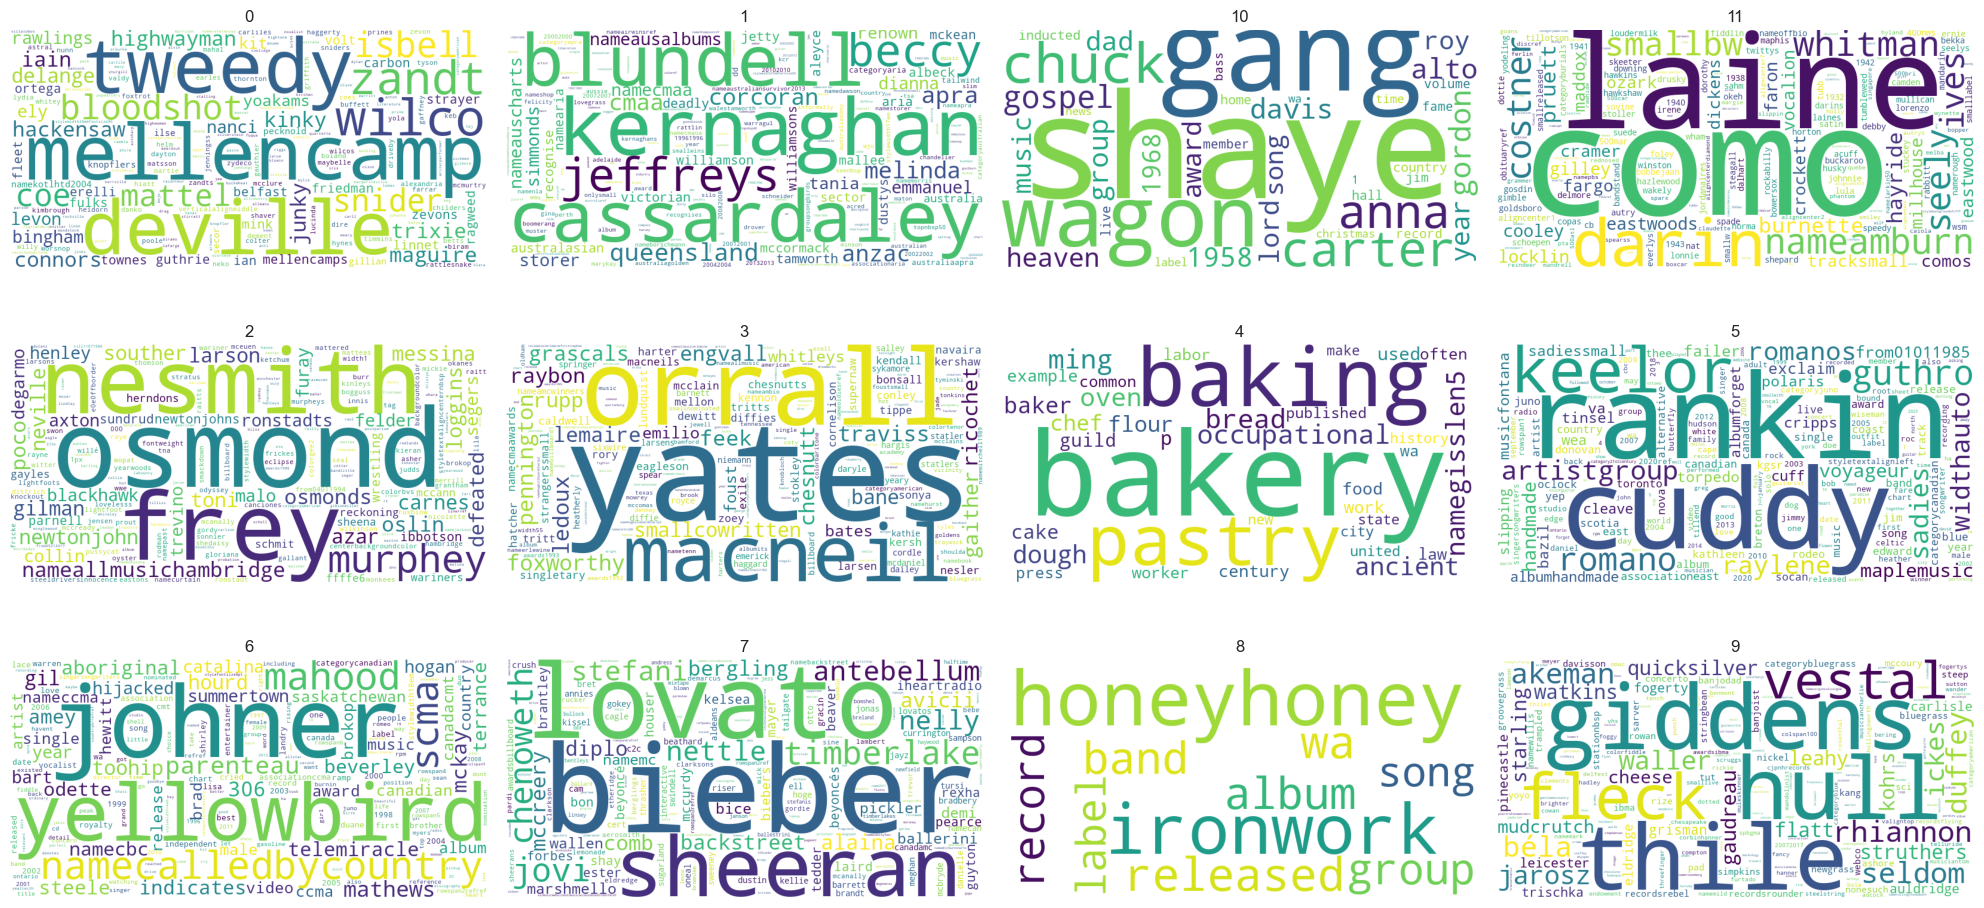

In [103]:
file_dir = "./data/TF_louvain"
plot_wordclouds(file_dir, IDF_louvain)

Word clouds for genres:

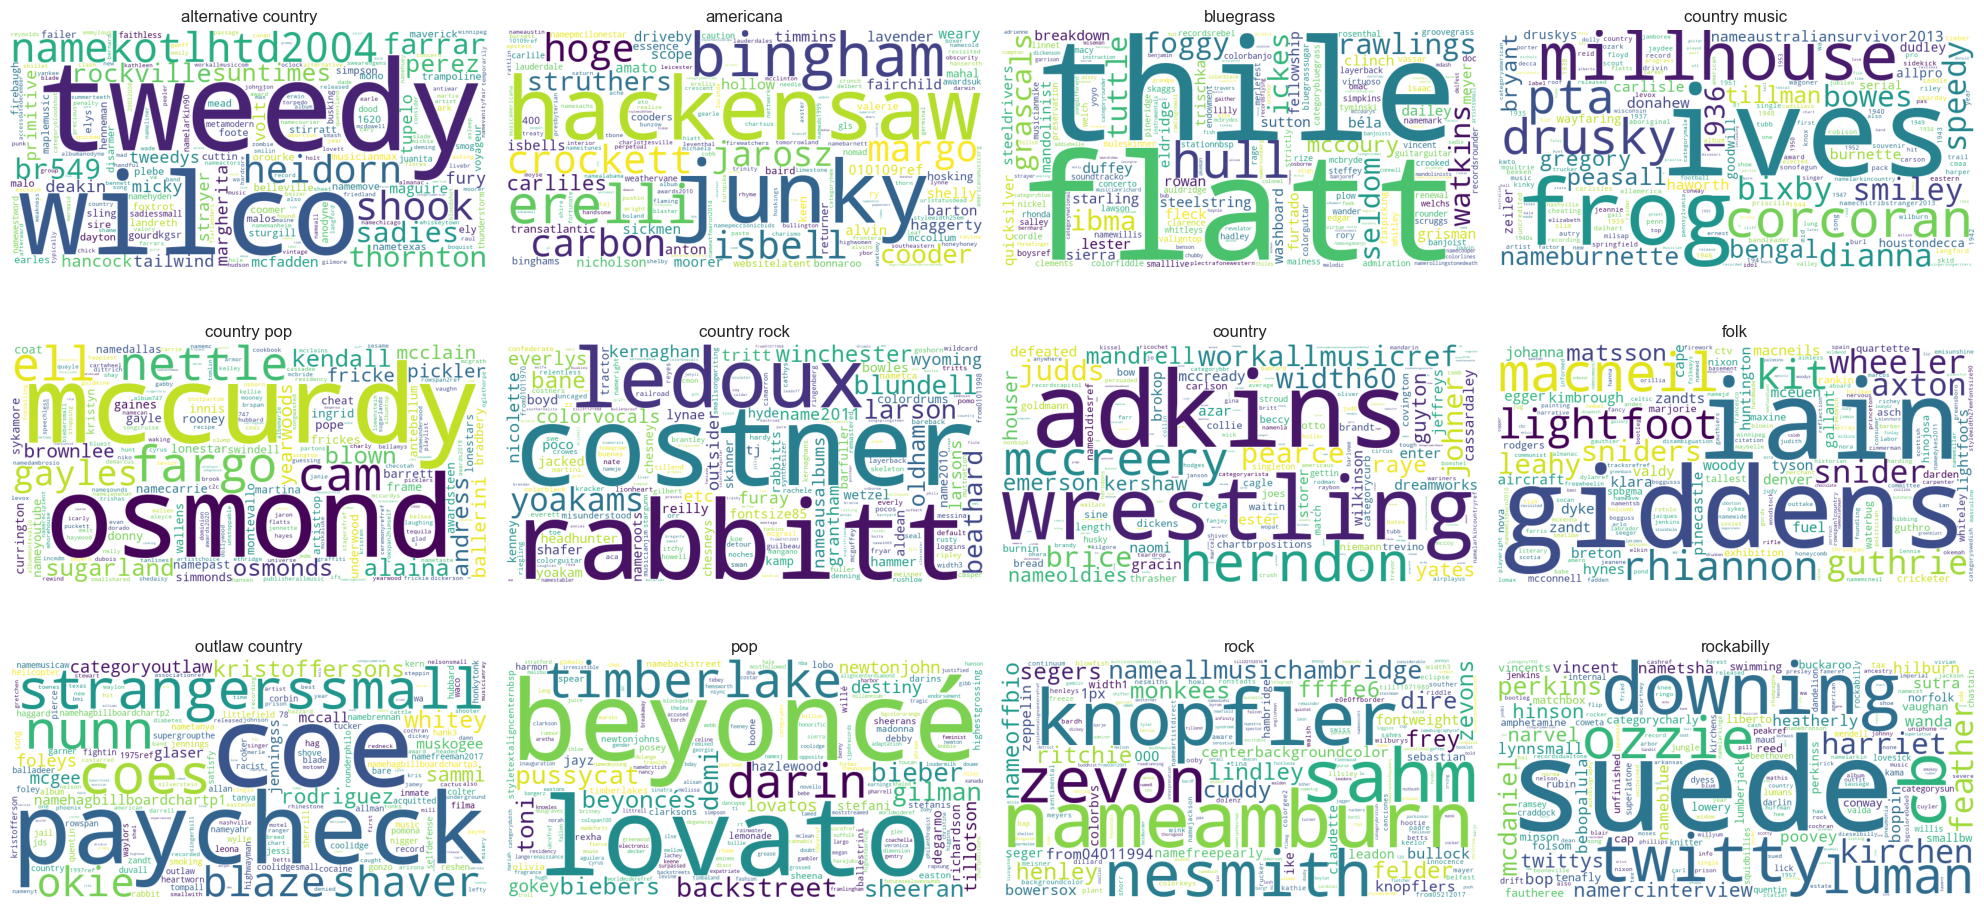

In [104]:
file_dir = "./data/TF_genres"
plot_wordclouds(file_dir, IDF_genres)

### **Exercise 2.3: Discussing the difference between the word-clouds between genres and communities**

To-do:

- Discuss (using confusion matrix from previous exercise) the difference between word-clouds of genre communities and Louvain communities. Look at what the artists with a Louvain community has in common, since it is not (at least not only) based on genre?

# **Part 3: Sentiment of the artists and communities**

### **Exercise 3.1: Sentiment of the artist pages**

To-do:

- Histogram of sentiment across artists (don't crop). Do statistics. 

- Maybe a boxplot?? 

### **Exercise 3.2: Sentiment of the largest communities**